In [76]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels 
import seaborn as sns
import scipy.stats as ss
import pylab
import pymysql
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
import sklearn
import arch
import datetime as dt


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from tqdm import tqdm
from time import sleep
sns.set()

In [115]:
def read_csv(name:str):
    df = pd.read_csv(f'../data/processed/{name}.csv')
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace = True)
    df.asfreq('12H')
    return df

In [116]:
data_raw = read_csv('data_processed')
df = data_raw.copy()

In [120]:
df.head()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Norm_BNBUSDT
Date,,,,,,,,,,,,
2019-01-01 00:00:00,3707.54,133.75,0.04076,5.9592,NaN,100.000000,NaN,100.000000,NaN,100.000000,NaN,100.000000
2019-01-01 12:00:00,3797.14,139.10,0.04198,5.9910,2.416697,102.416697,4.000000,104.000000,2.993131,102.993131,0.533629,100.533629
2019-01-02 00:00:00,3787.97,147.81,0.04276,5.8970,-0.241498,102.169363,6.261682,110.512150,1.858028,104.906771,-1.569020,98.956236
2019-01-02 12:00:00,3858.56,152.01,0.04433,6.0510,1.863531,104.073321,2.841486,113.652336,3.671656,108.758587,2.611497,101.540475
2019-01-03 00:00:00,3804.00,146.50,0.04268,5.8300,-1.413999,102.601725,-3.624762,109.532710,-3.722084,104.710500,-3.652289,97.831924


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2292 entries, 2019-01-01 00:00:00 to 2022-02-19 12:00:00
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BTCUSDT       2292 non-null   float64
 1   ETHUSDT       2292 non-null   float64
 2   ADAUSDT       2292 non-null   float64
 3   BNBUSDT       2292 non-null   float64
 4   Ret_BTCUSDT   2291 non-null   float64
 5   Norm_BTCUSDT  2292 non-null   float64
 6   Ret_ETHUSDT   2291 non-null   float64
 7   Norm_ETHUSDT  2292 non-null   float64
 8   Ret_ADAUSDT   2291 non-null   float64
 9   Norm_ADAUSDT  2292 non-null   float64
 10  Ret_BNBUSDT   2291 non-null   float64
 11  Norm_BNBUSDT  2292 non-null   float64
dtypes: float64(12)
memory usage: 232.8 KB


In [122]:
df.describe()

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,Ret_BTCUSDT,Norm_BTCUSDT,Ret_ETHUSDT,Norm_ETHUSDT,Ret_ADAUSDT,Norm_ADAUSDT,Ret_BNBUSDT,Norm_BNBUSDT
count,2292.000000,2292.000000,2292.000000,2292.000000,2291.000000,2292.000000,2291.000000,2292.000000,2291.000000,2292.000000,2291.000000,2292.000000
mean,22774.333639,1170.135628,0.573866,152.320843,0.140871,614.270747,0.190651,874.867759,0.221458,1407.915102,0.257022,2556.061940
std,19136.461574,1365.887802,0.757068,199.783512,2.703489,516.149835,3.386146,1021.224525,4.048774,1857.380839,3.826789,3352.522347
min,3385.320000,102.610000,0.022290,5.468800,-23.536521,91.309062,-29.813473,76.717757,-30.108340,54.685967,-31.200628,91.770707
25%,8275.872500,180.887500,0.048885,17.385275,-0.944004,223.217349,-1.252829,135.242991,-1.763342,119.933759,-1.447705,291.738404
50%,10848.475000,317.780000,0.095555,28.050550,0.113320,292.605744,0.126698,237.592523,0.046577,234.433268,0.121884,470.709995
75%,40509.595000,2152.052500,1.202082,317.117500,1.250208,1092.627322,1.754661,1609.011215,2.017779,2949.171982,1.915729,5321.477715
max,67594.980000,4807.980000,3.048000,676.150000,17.633807,1823.176014,18.345390,3594.751402,23.258978,7477.919529,35.598364,11346.321654


In [123]:
df.isna().sum()

BTCUSDT         0
ETHUSDT         0
ADAUSDT         0
BNBUSDT         0
Ret_BTCUSDT     1
Norm_BTCUSDT    0
Ret_ETHUSDT     1
Norm_ETHUSDT    0
Ret_ADAUSDT     1
Norm_ADAUSDT    0
Ret_BNBUSDT     1
Norm_BNBUSDT    0
dtype: int64

In [166]:
def plot(df, columns):
    fig, ax = plt.subplots(figsize=(22, 8))
    for column in columns:
        df[column].plot(ax=ax, label=column)
    plt.title(f"Plot of {', '.join(columns)}", fontsize = 20)
    plt.legend(fontsize = 15)
    file_name = "_".join(columns) + "_plot.png"
    # plt.savefig(f'../reports/figures/{file_name}')
    plt.show()


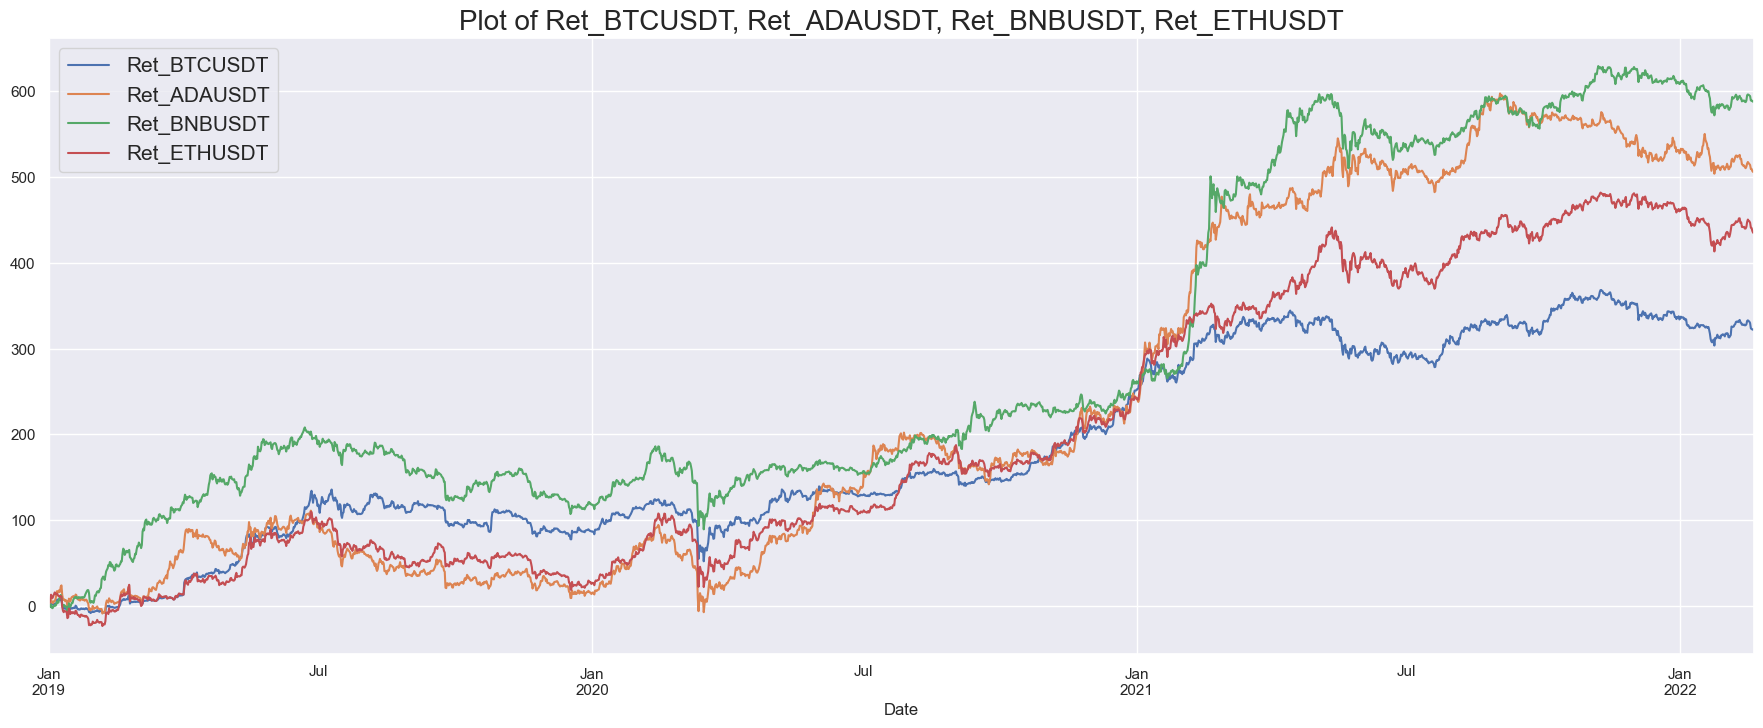

In [165]:
plot(df, ['Ret_BTCUSDT', 'Ret_ADAUSDT', 'Ret_BNBUSDT', 'Ret_ETHUSDT'])

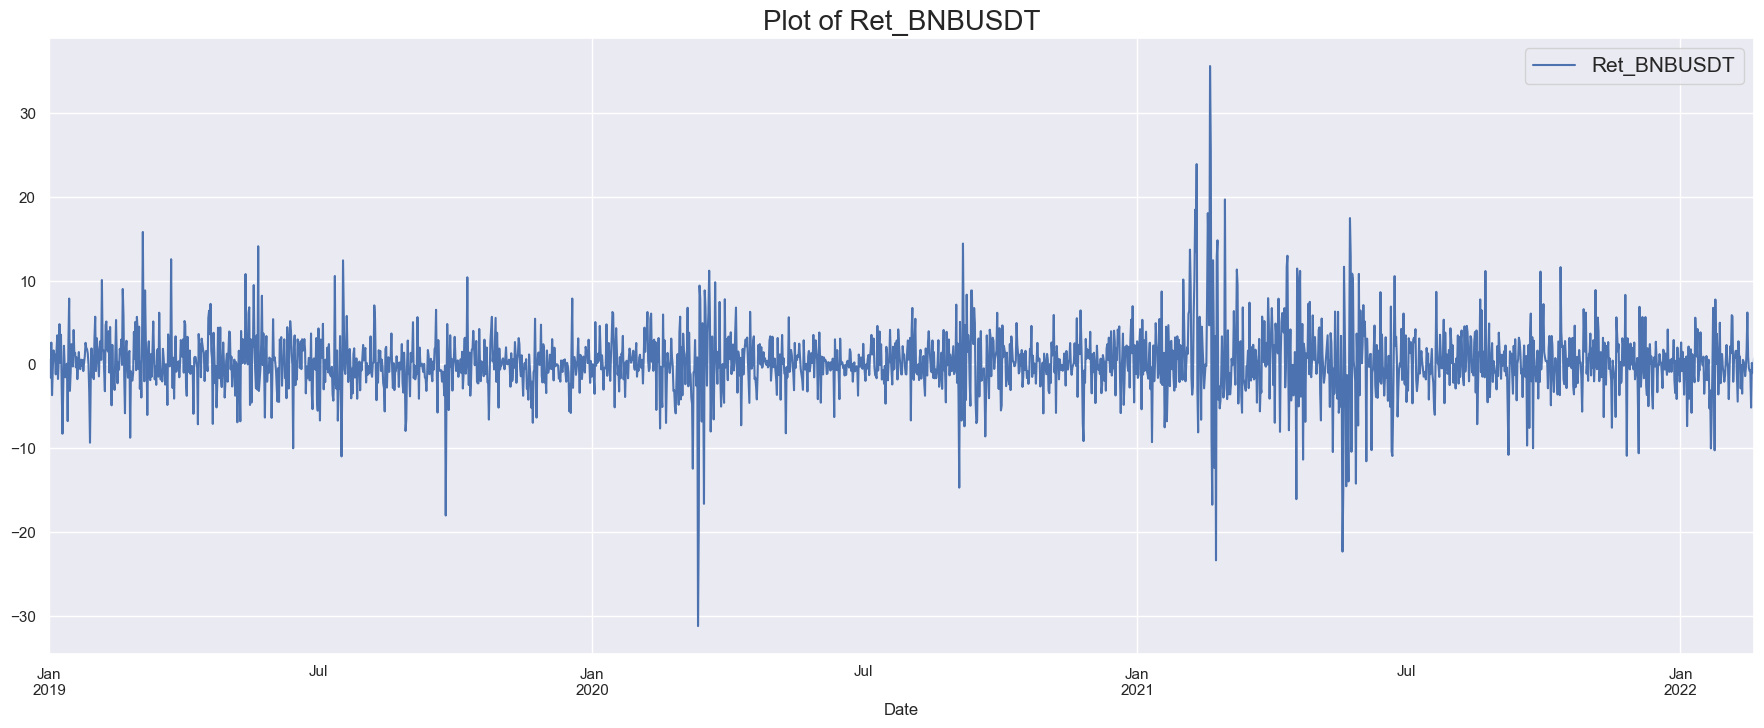

In [168]:
plot(df, ['Ret_BNBUSDT'])

## QQ Plot

In [154]:
def qqplot(df, column):
    fig, ax = plt.subplots(figsize=(12, 8))
    ss.probplot(df[column], plot=plt)
    plt.title(f"Q-Q Plot of {column}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Ordered Values")
    
    
    # Generate the file name based on the column name
    file_name = f"{column}_qqplot.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()



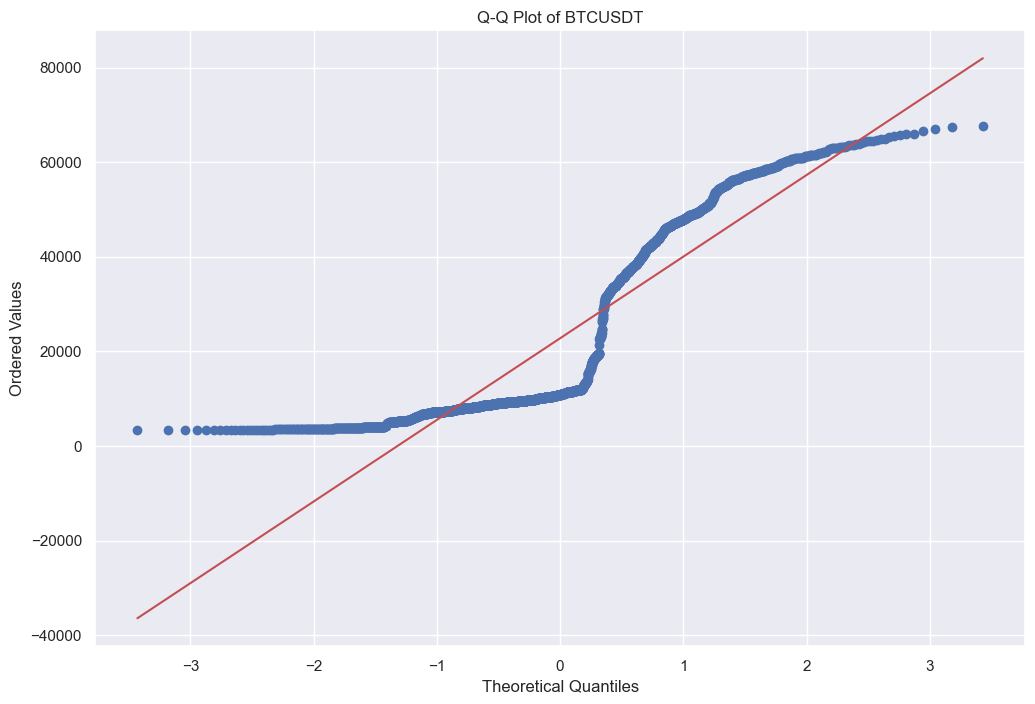

In [169]:
qqplot(df, 'BTCUSDT' )

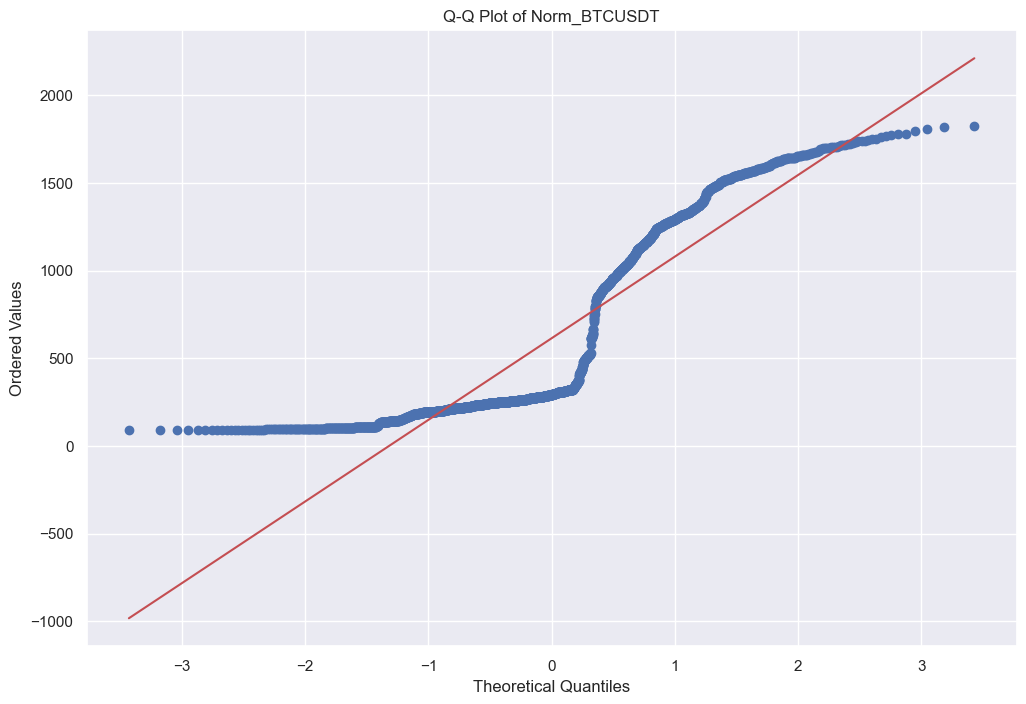

In [157]:
qqplot(df, 'Norm_BTCUSDT')

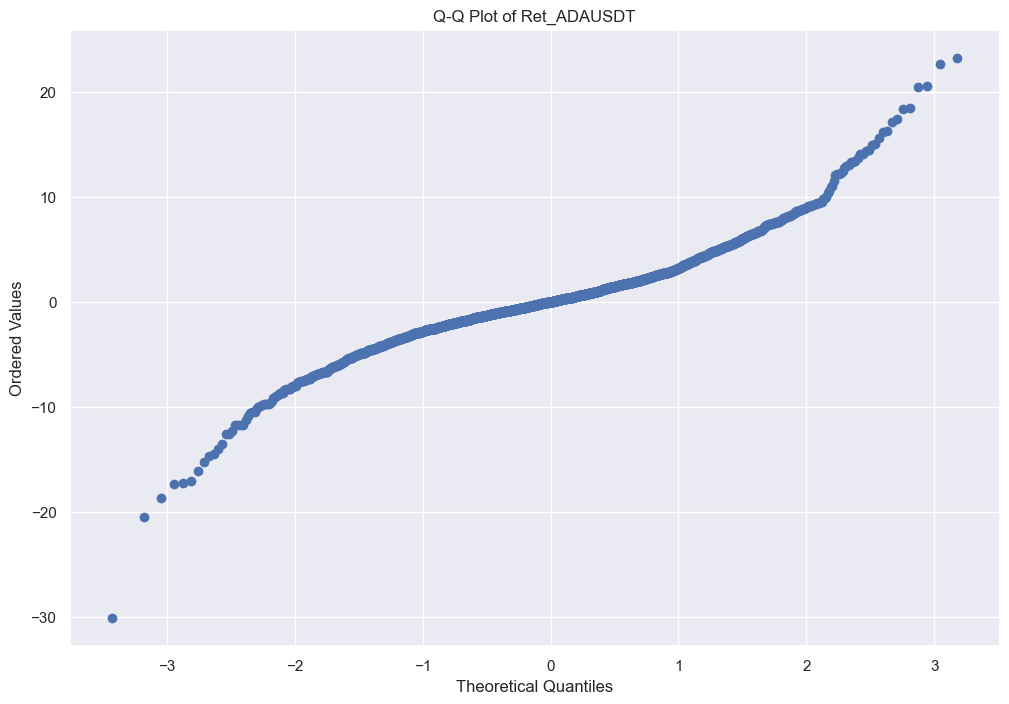

In [158]:
qqplot(df, 'Ret_ADAUSDT')

### The QQ Plot indicates that values are not normally distributed, more data in the 5000 to 2000 region 

## Test of stationality
##### ADF Test Results for BTCUSDT Closing Prices

The Augmented Dickey-Fuller (ADF) test was conducted on the BTCUSDT closing prices. The purpose of this test is to determine whether the series is stationary or non-stationary.

- Test Statistic: -1.465
- p-value: 0.55

The test statistic of -1.658 is less negative than the critical values at all significance levels (1%, 5%, and 10%). Additionally, the p-value of 0.453 is greater than the commonly used significance level of 0.05. These results indicate that there is insufficient evidence to reject the null hypothesis of non-stationarity.

Therefore, based on the ADF test, the BTCUSDT closing prices are likely non-stationary, suggesting the presence of trends or other forms of non-random behavior.


In [181]:
sts.adfuller(df.Norm_BTCUSDT.iloc[1:])

(-1.1431561463761017,
 0.6975586477710385,
 12,
 2278,
 {'1%': -3.433223873595976,
  '5%': -2.862809607710201,
  '10%': -2.5674458705439904},
 20656.616124476208)

## Test of Seasonality

In [185]:
def seasonal_decompose_plots(df, column):
    result = seasonal_decompose(df[column], model='additive')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    
    axes[0].plot(result.observed)
    axes[0].set_ylabel('Observed')
    
    axes[1].plot(result.trend)
    axes[1].set_ylabel('Trend')
    
    axes[2].plot(result.seasonal)
    axes[2].set_ylabel('Seasonal')
    
    axes[3].plot(result.resid)
    axes[3].set_ylabel('Residual')
    
    plt.tight_layout()
    
    df[f'resid_{column}'] = result.resid
    # Generate the file name based on the column name
    file_name = f"{column}_decompose_additive.png"
    
    # Save the figure in the specified directory
    plt.savefig(f'../reports/figures/{file_name}')
    plt.show()
    return 


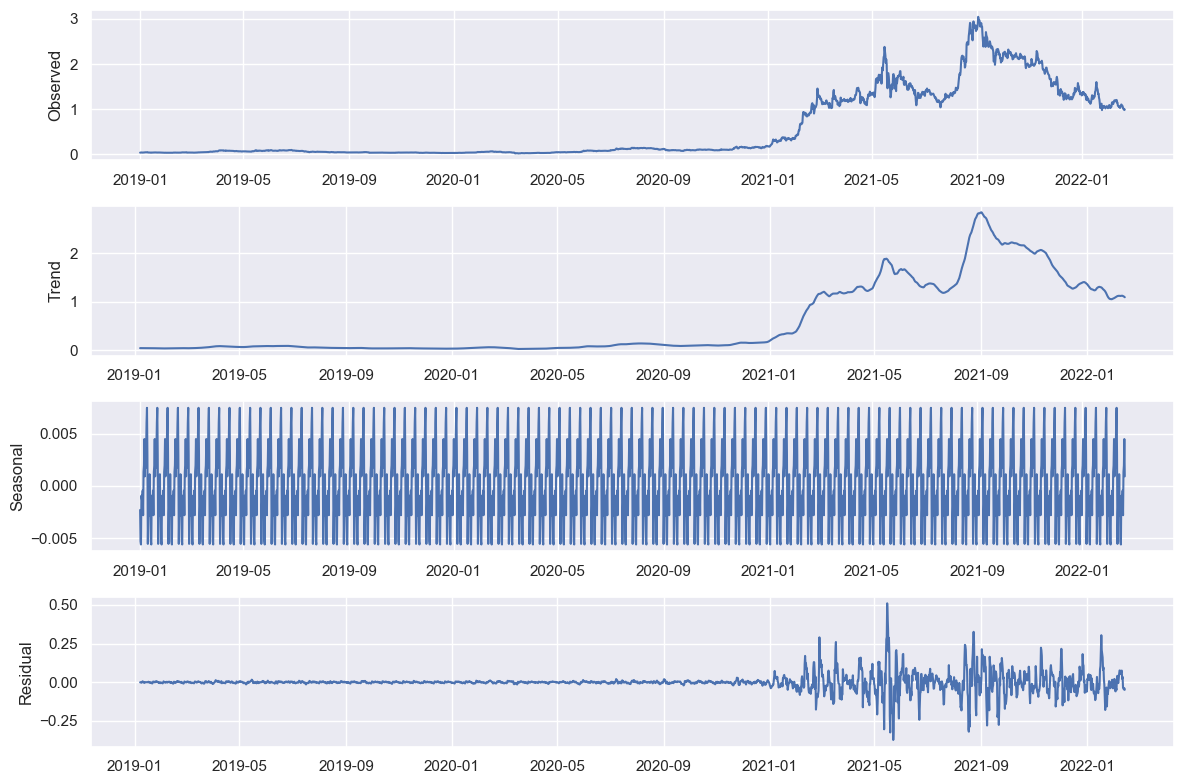

In [186]:
seasonal_decompose_plots(df,'ADAUSDT')

In [190]:
df.resid_ADAUSDT.std()

0.05545529561821817

### seasonal decompose plot show that there is no seasonality in the data which means that the btcusdt is not a seasonal data also the residual shows that there was some instablity in the data in 2021 up untill eaily 2022

## Plotting ACF

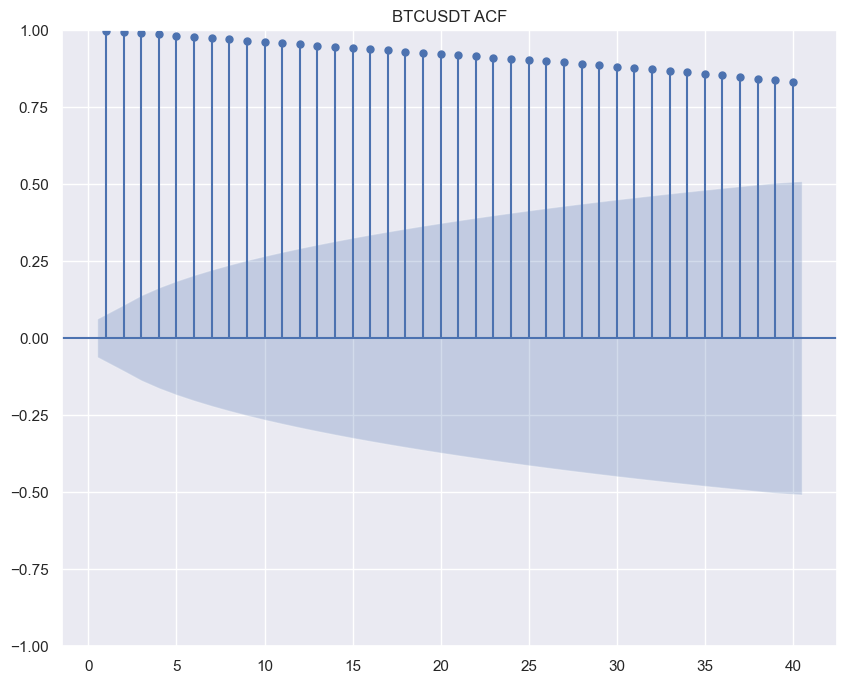

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))  
sgt.plot_acf(df.Close, lags=40, zero=False, ax=ax)
plt.title("BTCUSDT ACF")
plt.savefig('../reports/figures/btcusdt_acf')
plt.show()


### This acf suggest that coefficient are signficant which shows time dependance in the data also the shows that prices 30 days ago and beyond isnt really a good indicator of current prices

## PACF

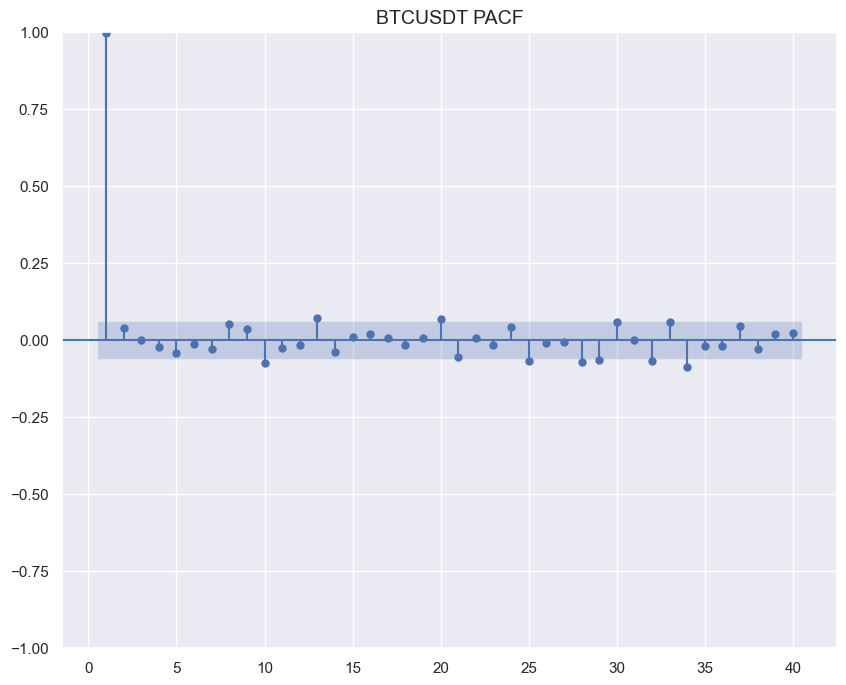

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))  
sgt.plot_pacf(df.Close, lags=40, zero=False, ax=ax, method=('ols'))
plt.title("BTCUSDT PACF", size = 14)
plt.savefig('../reports/figures/btcusdt_pacf')
plt.show()




### the pacf shows that the previous lags has little to no effect on the current price 

#### AR model

In [21]:
df = df.asfreq('d')

In [41]:
model_ar = ARIMA(df.Close, order = (15, 0, 0))
summary_ar = model_ar.fit()

In [42]:
summary_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  998
Model:                ARIMA(15, 0, 0)   Log Likelihood               -8587.562
Date:                Tue, 13 Jun 2023   AIC                          17209.124
Time:                        15:57:39   BIC                          17292.522
Sample:                    01-01-2020   HQIC                         17240.824
                         - 09-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.994e+04   8763.955      3.416      0.001    1.28e+04    4.71e+04
ar.L1          0.9602      0.027     35.392      0.000       0.907       1.013
ar.L2          0.0432      0.036      1.192      0.233      -0.028       0.114
ar.L3          0.0256      0.040      0.632      0.527      -0.054       0.105
ar.L4          0.0060      0.036      0.168      0.867      -0.064       0.076
ar.L5         -0.0292      0.034     -0.867      0.386      -0.095       0.037
ar.L6          0.0191      0.036      0.538      0.590      -0.051       0.089
ar.L7         -0.0831      0.034     -2.445      0.014      -0.150      -0.016
ar.L8          0.0254      0.029      0.861      0.389      -0.032       0.083
ar.L9          0.1039      0.032      3.266      0.001       0.042       0.166
ar.L10        -0.0483      0.035     -1.382      0.167      -0.117       0.020
ar.L11        -0.0129      0.035     -0.370      0.712      -0.082       0.056
ar.L12        -0.0803      0.031     -2.612      0.009      -0.141      -0.020
ar.L13         0.1054      0.031      3.362      0.001       0.044       0.167
ar.L14        -0.0478      0.033     -1.438      0.150      -0.113       0.017
ar.L15         0.0092      0.023      0.398      0.691      -0.036       0.054
sigma2      1.757e+06     15.111   1.16e+05      0.000    1.76e+06    1.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               771.43
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.46   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.69e+21. Standard errors may be unstable.
"""